# Effective Kraus Rank Fitting

In [31]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Synthetic Benchmark

### Generate Ground Truth

In [52]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 4
c1 = 0.9
c2 = 0.9

#prep error and full POVM error
spam_target = SPAM(d=d)

init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

kraus_target = DilutedKrausMap( 
                        U=generate_unitary(d=d), 
                        c=0.5, 
                        d=d, 
                        rank=rank-1,
                        spam = spam_target
                        )

### Generate Synthetic Data

In [53]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)
targets_spam = add_noise_to_probs(targets_spam, 0.01)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = 4000, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_channel(state)
targets_map = measurement(state, U_basis, spam_target.povm) 
targets_map = add_noise_to_probs(targets_map, 0.01)

targets_map_train = targets_map[:2000]
targets_map_val = targets_map[2000:]

inputs_map_train = [inputs_map[0][:2000], inputs_map[1][:2000]]
inputs_map_val = [inputs_map[0][2000:], inputs_map[1][2000:]]


inputs_entangle, _ = generate_pauli_circuits_entangled(n = n, 
                                                       circuit_target=None, 
                                                       N = 500, 
                                                       trace=False)
U_prep, U_basis = inputs_entangle

N_entangle = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_entangle, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_channel(state)
targets_entangle = measurement(state, U_basis, spam_target.povm) 
targets_entangle = add_noise_to_probs(targets_entangle, 0.01)

### Fit SPAM Model

In [54]:
spam_model = SPAM(d=d, optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    verbose = False,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

3.0155585825323288e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0006075390030352757


## Un Regularized

In [55]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for rank in tqdm(range(1,17)):
    kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )
    
    model = ModelQuantumMap(
                            channel = kraus_model,
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = ProbabilityMSE(), verbose=False)
                            )
    
    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 2000,
                N = 500,
               )
    model_list.append(model)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.1565175766565816 0.1631844455542416


  0%|          | 0/2000 [00:00<?, ?it/s]

0.049823918605510616 0.052291801581612535


  0%|          | 0/2000 [00:00<?, ?it/s]

0.016241244439988967 0.01699404970565588


  0%|          | 0/2000 [00:00<?, ?it/s]

0.000997496441927006 0.0010810788832432948


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009630136879409171 0.001068055870935686


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009384550125790776 0.0010435916298672375


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009252786020506666 0.0010438046226207355


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009240764193593145 0.0010427562477389053


  0%|          | 0/2000 [00:00<?, ?it/s]

0.000916414974454599 0.0010406794725397906


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009135764932657895 0.001035761162421229


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009138409124361249 0.00104347452562026


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009092460995906455 0.001041283976739754


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009072039217670667 0.0010385451641760199


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009105862355209614 0.0010411346281853514


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009109670252197574 0.0010385266458886148


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009067775504117438 0.001034471494521764


In [56]:
loss_train = [model.logger.loss_train_list[-1] for model in model_list]
loss_val = [model.logger.loss_val_list[-1] for model in model_list]
loss_entangled = [model.loss_function[0](model.channel, inputs_entangle, targets_entangle) for model in model_list]
fidelity = [channel_fidelity(kraus_target, model.channel) for model in model_list]

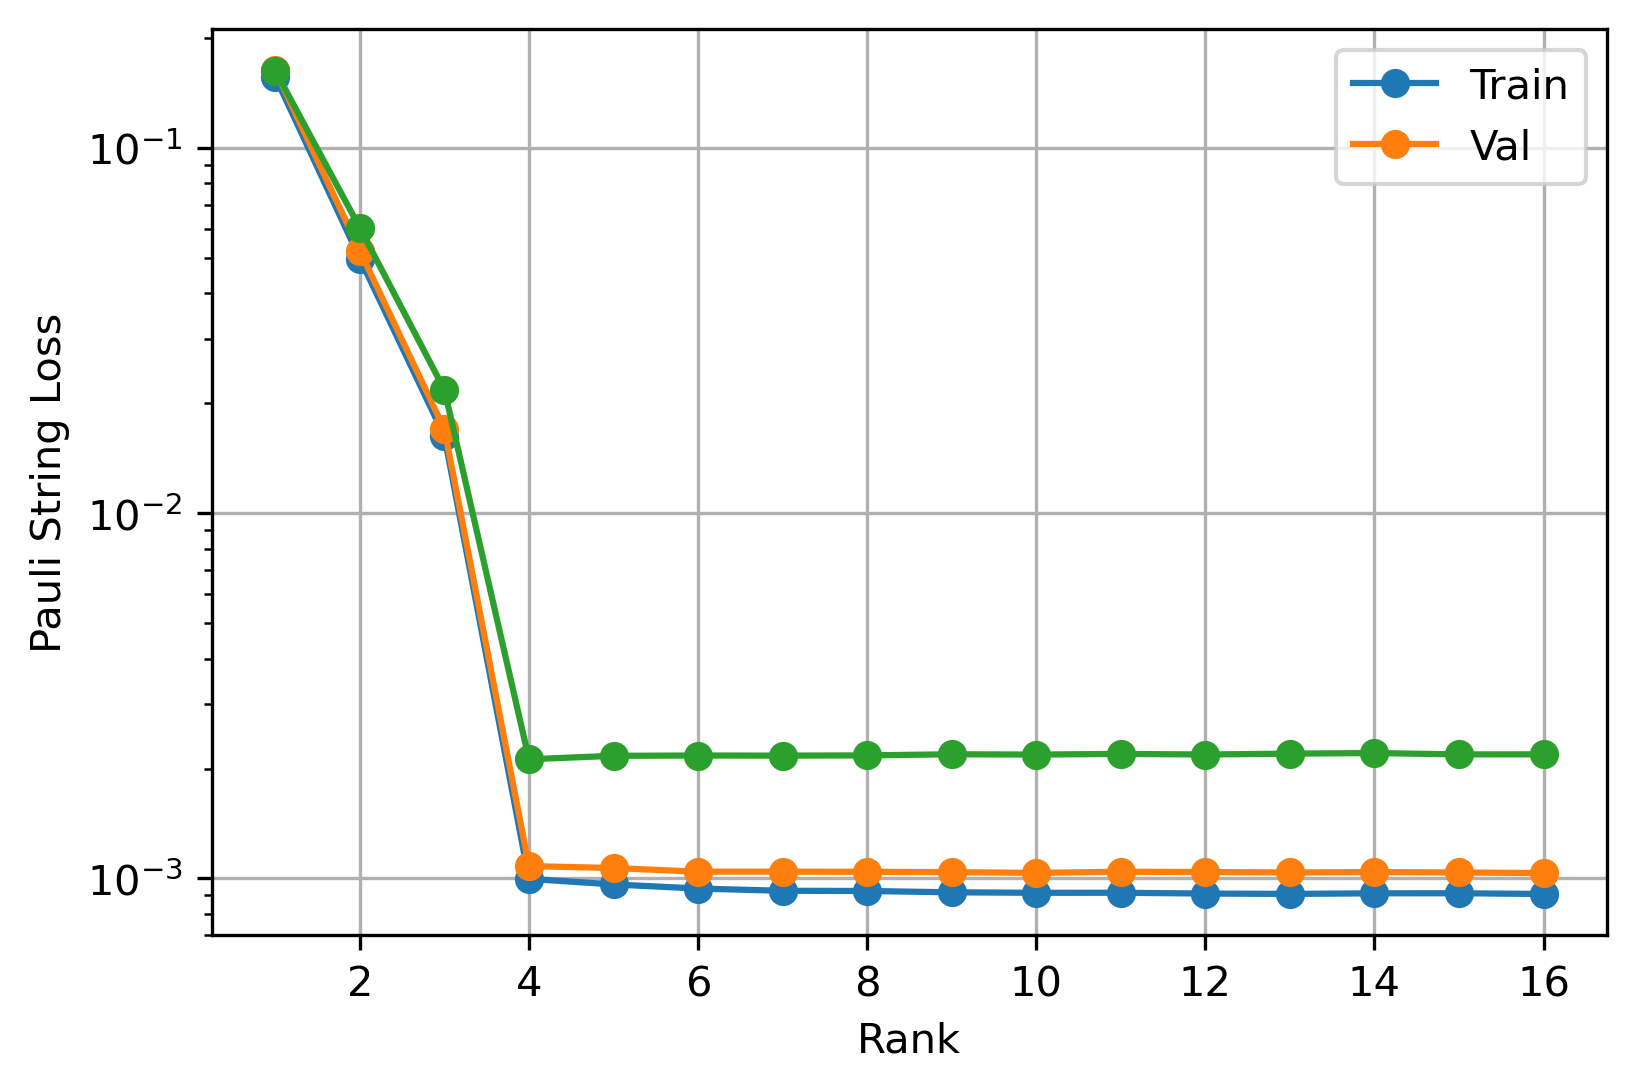

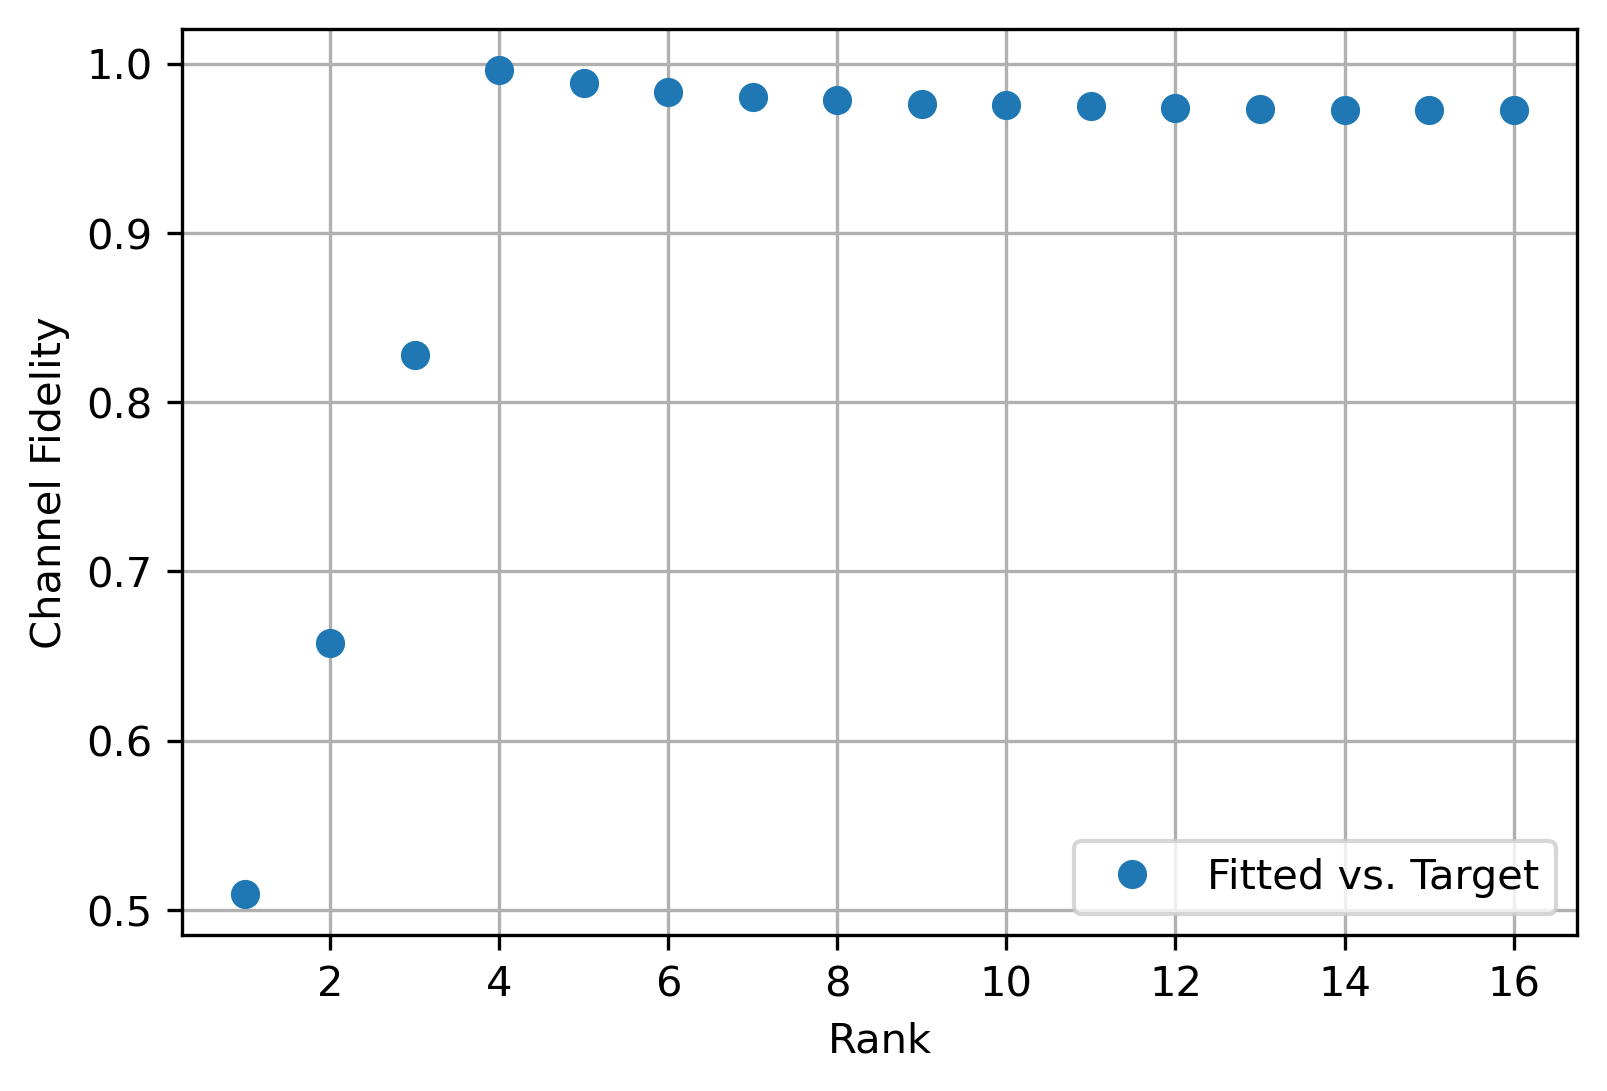

In [59]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train, "-o")
plt.plot(list(range(1,17)), loss_val, "-o")
plt.plot(list(range(1,17)), loss_entangled, "-o")
plt.grid()
plt.yscale("log")
plt.legend(["Train","Val"])

plt.show()

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Channel Fidelity")
plt.plot(list(range(1,17)) ,fidelity, "o")
plt.legend(["Fitted vs. Target"])
plt.grid()
plt.show()

## Regularized

In [32]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for rank in tqdm(range(1,17)):
    kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )
    
    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = ProbabilityLoss(reg=0.001),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )
    
    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 2000,
                N = 500,
                verbose = False
               )
    model_list.append(model)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.14592344166214272 0.15067295548049145


  0%|          | 0/2000 [00:00<?, ?it/s]

0.05598887326643503 0.05921959615249247


  0%|          | 0/2000 [00:00<?, ?it/s]

0.027446480984681346 0.02801651386628108


  0%|          | 0/2000 [00:00<?, ?it/s]

0.015595288984461574 0.016147480681460505


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010016169169898545 0.010716597765038966


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006921658263921207 0.007293398272268367


  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
loss_train = [model.loss_train[-1] for model in model_list]
loss_val = [model.loss_val[-1] for model in model_list]
fidelity = [channel_fidelity(kraus_target, model.q_map) for model in model_list]

In [ ]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train, "-o")
plt.plot(list(range(1,17)), loss_val, "-o")
plt.grid()
plt.legend(["Train","Val"])

plt.show()

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Channel Fidelity")
plt.plot(list(range(1,17)) ,fidelity, "o")
plt.ylim([0.5, 1.1])
plt.legend(["Fitted vs. Target"])
plt.grid()
plt.show()

## Max Rank Fitting

### No Reg

In [10]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_restricted = KrausMap(
                       d = d, 
                       rank = 8,
                       spam = spam_model,
                       )
    
model_restricted = ModelQuantumMap(
                                   q_map = kraus_restricted,
                                   loss = ProbabilityLoss(),
                                   optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                  )

model_restricted.train(inputs = inputs_map_train,
                       targets = targets_map_train,
                       inputs_val = inputs_map_val,
                       targets_val = targets_map_val,
                       num_iter = 2000,
                       N = 500,
                       verbose = False
                       )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009920047559402974 0.0010802287252033816


In [6]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_full = KrausMap(
                       d = d, 
                       rank = d**2,
                       spam = spam_model,
                       )
    
model_full = ModelQuantumMap(
                            q_map = kraus_full,
                            loss = ProbabilityLoss(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                             )
                
model_full.train(inputs = inputs_map_train,
                 targets = targets_map_train,
                 inputs_val = inputs_map_val,
                 targets_val = targets_map_val,
                 num_iter = 2000,
                 N = 500,
                 verbose = False
                 )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0009179792465390901 0.0010133073721825998


In [7]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model_reg = KrausMap(
                           d = d, 
                           rank = d**2,
                           spam = spam_model,
                           )
    
model_reg = ModelQuantumMap(
                            q_map = kraus_model_reg,
                            loss = ProbabilityLoss(0.0005),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

model_reg.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 2000,
                N = 500,
                verbose = False
               )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00265004338964894 0.002729110131860314


In [11]:
print(effective_rank(kraus_target))
print(effective_rank(model_restricted.q_map))
print(effective_rank(model_full.q_map))
print(effective_rank(model_reg.q_map))

tf.Tensor((3.401312642541428+5.372187488950124e-16j), shape=(), dtype=complex128)
tf.Tensor((3.4145504577216377+2.754056154153428e-16j), shape=(), dtype=complex128)
tf.Tensor((3.515083682435106+2.5316740508587954e-16j), shape=(), dtype=complex128)
tf.Tensor((3.4120393400828175+8.360887541801862e-17j), shape=(), dtype=complex128)


In [12]:
fid_restricted= channel_fidelity(kraus_target, model_restricted.q_map)
fid_full = channel_fidelity(kraus_target, model_full.q_map)
fid_reg = channel_fidelity(kraus_target, model_reg.q_map)

print(fid_restricted)
print(fid_full)
print(fid_reg)

tf.Tensor(0.994378241997473, shape=(), dtype=float64)
tf.Tensor(0.9640021918528098, shape=(), dtype=float64)
tf.Tensor(0.9732748456405489, shape=(), dtype=float64)


## Observation: 

Loss on validation Pauli Strings is strictly decreasing, even for rank>true rank. But channel fidelity shows that rank>true rank causes overfitting not detected by testing on unseen Pauli strings. Why? Hypothesis: Over parameterized models introduce incorrect effects that neither detected or corrected by just simple pauli strings; They go under the radar. But, channel fidelity and train/val loss correspond very nicely up until rank saturation. This is easily detected, from the plot

## Real Hardware

In [64]:
inputs_map, inputs_spam, inputs_entangle, counts_map_list =  pickle.load(open("../../data/threeQubits_PQC_belem_entangled_pauli.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:2000-6**n])
targets_spam = counts_to_probs(counts_map_list[2000-6**n:2000])
targets_entangle = counts_to_probs(counts_map_list[2000:])

inputs_train, targets_train, inputs_val, targets_val = train_val_split(inputs_map, targets_map, ratio=0.9)

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 2000,
                 verbose = False,
                 )

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009403139843185172


In [65]:
model_list = []
for i in tqdm(range(1, 17)):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            channel= kraus_model,
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = ProbabilityMSE(), verbose=False)
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 2000,
                N = 500
                )
    
    model_list.append(model)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.22063055295320516 0.22857087808326787


  0%|          | 0/2000 [00:00<?, ?it/s]

0.06520095770279338 0.06862250667160086


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02532023275701394 0.02661705390242694


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0046199014946025855 0.004827996000883561


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0033468953007221545 0.003627177766959559


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027576376466612387 0.0031584811889331364


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002392785707100912 0.002793216664308321


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002181610958362151 0.0025658589518448346


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0020496687916878808 0.0024562859511092954


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0019580181681857355 0.0023573428150654866


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0018976003031618838 0.002297013181039423


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0018675407264029315 0.002258410294666743


  0%|          | 0/2000 [00:00<?, ?it/s]

0.001834674211512233 0.0022201639662400375


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017949847937095936 0.002201142621937034


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017720854813305087 0.0021790540371093695


  0%|          | 0/2000 [00:00<?, ?it/s]

0.001752568841668516 0.002156348415973749


In [66]:
loss_train = [model.logger.loss_train_list[-1] for model in model_list]
loss_val = [model.logger.loss_val_list[-1] for model in model_list]
loss_entangled = [model.loss_function[0](model.channel, inputs_entangle, targets_entangle) for model in model_list]

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


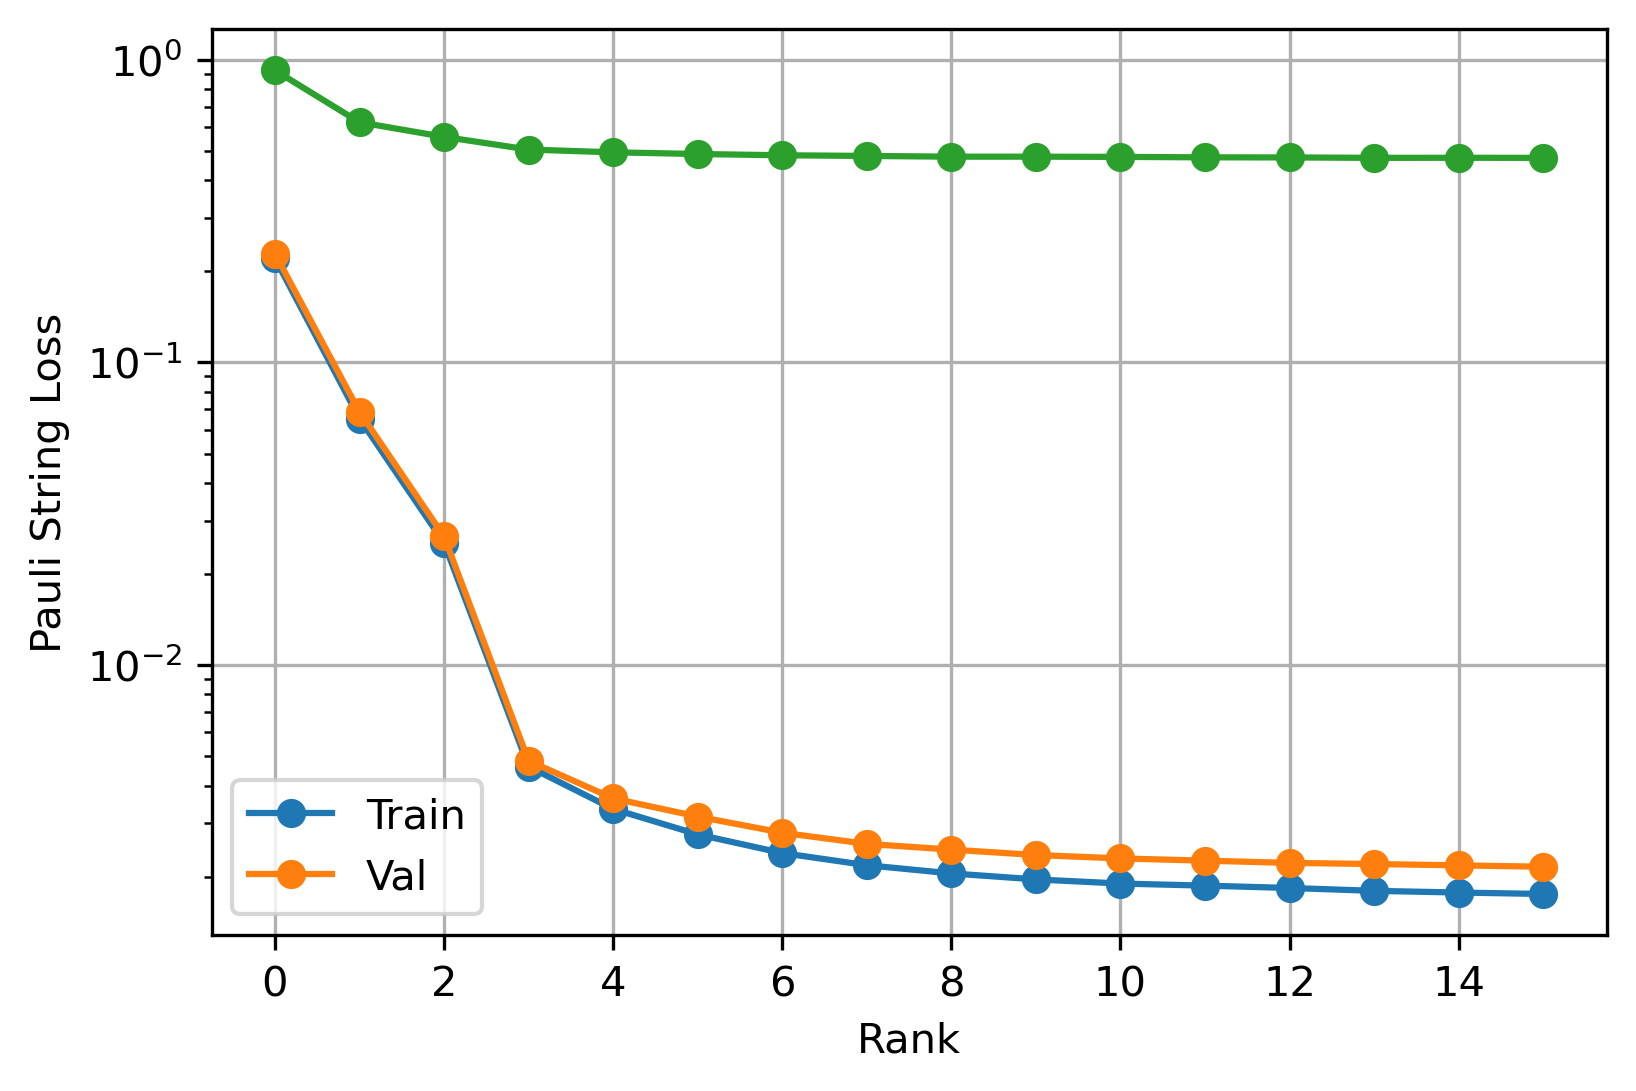

In [67]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
plt.grid()
plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")

plt.plot(loss_train, "-o")
plt.plot(loss_val, "-o")
plt.plot(loss_entangled, "-o")

#plt.ylim([0, 0.02])
plt.yscale("log")
plt.legend(["Train","Val"])
plt.show()

fig.savefig("../../latex/figures/variational_threeLayer_loss.pdf")

In [68]:
loss_entangled

[<tf.Tensor: shape=(), dtype=complex128, numpy=(0.9225595458065832-1.477317897495451e-17j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.6215689999032739-2.335564459301651e-18j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.556118209029813-5.340694443728202e-20j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.5050208976791742-2.9334605224009105e-18j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.4945117251200427+1.935148927547629e-18j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.48815122001594635+3.208530393208097e-18j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.4835147928432865+8.428756739454078e-19j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.4810454151367291+6.399270036155159e-19j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.4783901376676571-4.608619378793205e-19j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.47837164581516756+2.406099343116817e-18j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(0.47759336580003026+